In [33]:
# Set the number of number of OMP threads to 1
%env OMP_NUM_THREADS=1

# Update path including qFlex root
import sys, os
sys.path.insert(1, os.path.dirname('./../'))

from python import qflex
from python import utils
from python.ordering import order_circuit_simulation as order_lib
from python.circuits import generator
from progressbar import progressbar as pb
from io import StringIO
from multiprocessing import Pool
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import cirq

env: OMP_NUM_THREADS=1


In [34]:
# Get ordering
def get_ordering(grid, circuit):
    qubits = utils.GetGridQubits(StringIO('\n'.join(grid)))
    circuit = utils.GetCircuit(StringIO('\n'.join(circuit)), qubits)
    return order_lib.circuit_to_ordering(circuit, qubit_names=sorted(qubits))

In [35]:
# Define grid
grid = """1111
1111
1111
1111""".split('\n')

In [36]:
# Define gates
q1_gates = ["x_1_2", "y_1_2", "t"]
q2_gate = "cx"

In [37]:
# Define patterns for the generation of RQCs
patterns = {
  'A' : {(i,i+1) for i in range(0,16,2)},
  'B' : {(i,i+1) for i in range(1,16,4)},
  'C' : {(i,i+4) for i in chain(range(0,4),range(8,12))},
  'D' : {(i,i+4) for i in range(4,8)}
}

# Define the sequence of patterns
sequence = "ACBD"

# Define the depth of the circuit
depth = 12

# Get qubits map
qubits_map = {}
for x,k in enumerate(int(y) for x in grid for y in x):
    if k != 0:
        qubits_map[len(qubits_map)] = x

In [38]:
# Get a generator of RQCs
prqcg = generator.PseudoRandomCircuitGenerator(
            generator.Device(patterns),
            q1_gates, 
            q2_gate)

def get_rqc():

    # Get a RQC ...
    rqc = prqcg.generate(sequence, depth, None)
  
    # ... and remap them accordingly to layout
    rqc = [' '.join([str(int(x[0])+1)]+[x[1]]+[str(qubits_map[int(y)]) for y in x[2:]]) 
            for x in (x.split() for x in rqc.to_qsim_lines())]
  
    # Add layer of hadamard at the beginning and end
    rqc = ['0 h ' + str(qubits_map[q]) for q in range(len(qubits_map))] + rqc
    rqc = rqc + [str(int(rqc[-1].split()[0])+1) + ' h ' + str(qubits_map[q]) for q in range(len(qubits_map))]
  
    # Add number of qubits at the beginning
    rqc.insert(0, str(len(qubits_map)))
  
    return rqc

In [39]:
# Get ordering
ordering = get_ordering(grid, [x for x in get_rqc() if len(x.split()) == 4])

In [40]:
# Get unique set of states
def get_unique_states(num_qubits, num_states):
    states = set()
    while(len(states) != num_states):
        states.add(bin(np.random.randint(2**num_qubits))[2:].zfill(num_qubits))
    return states

# Simulate the circuit using qFlex
def run_simulation(final_state):

    options = {
      'circuit': get_rqc(),
      'ordering': ordering,
      'grid': grid,
      'final_state' : final_state
    }
  
    return qflex.simulate(options)

# Number of desired amplitudes
num_amplitudes = 1000

states = list(get_unique_states(len(qubits_map), num_amplitudes))

with Pool(8) as pool:
    amplitudes = []
    for i in pb(range(int(len(states)/32)+(len(states)%32>0))):
        amplitudes.extend(pool.map(run_simulation, states[i*32:(i+1)*32]))

100% (32 of 32) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


In [41]:
# Given a dataset, return a bootstrapped histogram
def bootstrap_hist_data(data, num_bins=10, density=False, fraction_boostrap=0.75, bootstrap_rep=None):

    n = int(fraction_boostrap * len(data))
  
    if bootstrap_rep == None:
        bootstrap_rep = len(data)
  
    hist_hits, bins = np.histogram(data[[np.random.randint(len(data)) for _ in range(n)]], num_bins, density=density)
    if not density:
        hist_hits = hist_hits/len(data)
    var_hist_hits = hist_hits**2
  
    for _ in pb(range(bootstrap_rep-1)):
        h,b = np.histogram(data[[np.random.randint(len(data)) for _ in range(n)]], bins=bins, density=density)
        if not density:
            h = h/len(data)
  
        hist_hits += h
        var_hist_hits += h**2
  
    hist_hits = hist_hits/bootstrap_rep
    var_hist_hits = np.sqrt(var_hist_hits/bootstrap_rep - hist_hits**2)
  
    return bins, hist_hits, var_hist_hits

In [42]:
# Get a^2 for all ampltiudes
a2 = np.array([np.abs(x[0][1])**2 for x in amplitudes])

# Get bootstrapped histogram
N = 2**(len(qubits_map))
bins, hist_hits, var_hist_hits = bootstrap_hist_data(N * a2, num_bins=8, density=True)

100% (999 of 999) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


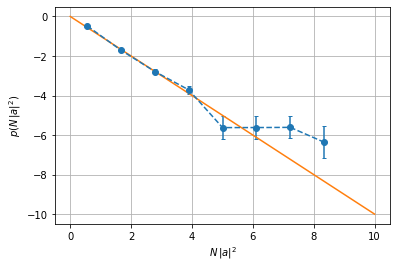

In [43]:
# Compute Porter-Thomas distribution
plt.errorbar((bins[1:] + bins[:-1]) / 2., np.log(hist_hits), var_hist_hits/hist_hits, ls='--', marker='o', capsize=2)
xs = np.linspace(0, 10, 100)
plt.plot(xs, -xs)
plt.xlabel('$N\,|a|^2$')
plt.ylabel('$p(N\,|a|^2)$')
plt.grid()
plt.show()

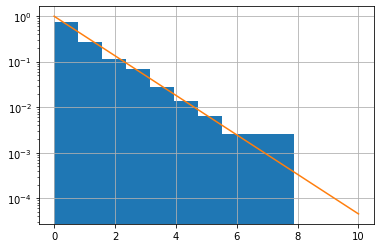

In [32]:
plt.hist(N * a2, bins=10, density=True)
plt.yscale('log')
xs = np.linspace(0, 10, 100)
plt.plot(xs, np.exp(-xs))
plt.grid()